In [10]:
%matplotlib inline

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import sys
import nltk
import gensim
import tensorflow as tf
import keras
import random
import seaborn as sns

from wordcloud import WordCloud
from transformers import pipeline
from collections import Counter
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise
from nltk.tokenize.treebank import TreebankWordDetokenizer
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from models.BERT import training_3 
from functions import *

In [ ]:
random.seed(42)
tf.random.set_seed(0)

# PubMed Articles Scoring

## Abstract

This project finds PubMed scientific articles connected to a specific illness and potential natural remedies for it (health substances and practices). After that, the AI algorithm scores their effectiveness (between 0 and 2), according to the tone of the articles.

## Introduction

The idea behind it is simple: a user of a app, who is interested in a specific disease, to be able to find alternative natural remedies immediately in a concise form. All the results are scored, according to their effectiveness, with the most proven ones at the top.

The platform that we built a scraper for is PubMed.

### What is PubMed?

PubMed is a free database that contains more than 35 million citations and abstracts of biomedical literature. Although it is developed and maintained by the US National Center for Biotechnology Information, the research available on the platform comes from all over the world. Therefore, it gives us access to the latest scientific discoveries worldwide.

##### PubMed and PubMed Central - what's the difference?

'PubMed is a biomedical literature database that contains the abstracts of publications in the database. PubMed Central is a full text repository, which contains the full text of publications in the database (<a href="https://libguides.library.arizona.edu/c.php?g=360488&p=2434686" target="_blank">source</a>).

Initially, we included texts from both sources - abstracts from the first and results and conclusions from the second platform while refining the algorithms' results. After that, we stuck to the abstracts and swapped all the text parts from PubMed Central with their abstracts. We couldn't do that only with one article because it was missing in the PubMed database. 

So, our dataset contains mainly abstracts. If an abstract has a conclusion part, we use only the conclusions.

### How the information is gathered

In order to find and download the abstracts related to the specific illness, a spider is used.

We built it specifically for the PubMed platform. It starts automatically the search for more than 2 000 health substances and practices in combination with the specific disease.

Because sometimes the keywords for the natural remedies can be the same as a scientist's name (like "Birch"), the bot checks the text and downloads it only if it contains the searched remedy. 

In some of the texts, though, the connection between a disease and a health substance/practice is indirect - for example, an article exploring whether patients with idiopathic normal pressure hydrocephalus are more physically active after shunt surgery. In this case, the effect of exercise on the illness are not examined.

We tried to minimize the results of such articles by our labeling. In the training set, we scored this kind of abstracts with 0, in order to motivate the algorithms to register these "loose" connections.           

### Measurements

Therefore we have three labels. When we scored the texts for training and testing, we scored them with 0 when we see this loose connection. 

A big part of the texts' tone was estimated as corresponding to one. This is due to the fact that, even though a remedy provides promising results, usually deeper research and more trials are needed in order for any substance or practice to be proven as a remedy.

The '2' score is reserved only for those papers which claim that the specific substance or practice is very effective. In some articles, there could be phrases suggesting that it could be used as treatment for the given disease.

Because we have three categories (0, 1, and 2), we are going to use accuracy as a measurement of to what extent the algorithm managed to label the abstract correctly.

## Data Exploration

We are going to use 32 labeled texts.

In [13]:
texts = pd.read_csv('data/only_abstracts.csv')

In [5]:
texts.head()

,text,title,score,illness,health_substance,url
0,Conclusion: While there is conflicting evidenc...,The effect of Omega-3 fatty acid supplementati...,1,"lupus erythematosus, sle",omega-3,https://pubmed.ncbi.nlm.nih.gov/35023407/
1,Conclusion: Resveratrol possesses protective e...,Resveratrol possesses protective effects in a ...,2,"lupus erythematosus, sle",resveratrol,https://pubmed.ncbi.nlm.nih.gov/25501752/
2,Abstract Nettle root is recommended for compla...,A comprehensive review on the stinging nettle ...,2,"benign prostatic hyperplasia, bph",stinging nettle,https://pubmed.ncbi.nlm.nih.gov/17509841/
3,"Abstract For decades, the focus of managing au...",Minerals: An Untapped Remedy for Autoimmune Hy...,1,"hashimoto’s thyroiditis, ht, hypothyroidism","minerals, zinc, selenium, magnesium, iron",https://pubmed.ncbi.nlm.nih.gov/33094039/
4,Abstract Background: Hashimoto's thyroiditis (...,Metformin Reverses Hashimoto’s Thyroiditis by ...,2,"hashimoto’s thyroiditis, ht, hypothyroidism",metformin,https://pubmed.ncbi.nlm.nih.gov/34124070/


#### Exploration

##### Word clouds

We are going to see if there are words used more often than the others with word clouds. 

What are these clouds? 

"The more commonly the term appears within the texts, the larger the word appears in the image generated. Word clouds are increasingly being employed as a simple tool to identify the focus of written material." <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3289811/" target="_blank">Source</a> 

Before we move on, there are a lot of stop words. Let's remove them first. We will remove line spaces and single quotes as well.

In [6]:
stopwords =set(nltk.corpus.stopwords.words("english"))

We are going to remove the capital letters and the short words (those smaller than 4 letters) in order to skip even more stopwords. 

In [17]:
temp = []
#Splitting pd.Series to list
data_to_list = texts['text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
data_words = list(sent_to_words(temp, 4))

Now we have every abstract in the form of a list of words - all with small letters. Here we see the first five words from the first text.

In [10]:
data_words[0][:5]

['conclusion', 'while', 'there', 'conflicting', 'evidence']

Now we are removing the stopwords.

In [11]:
words = [word for word in data_words if word not in list(stopwords)]

After removing the stopwords it will be interesting to see if there are differences in the most used words between the group of articles, scored with 2 and the other 2 groups.

In [12]:
two_scored_indices = texts[texts['score'] == 2].index

In [13]:
one_scored_indices = texts[texts['score'] == 1].index

In [14]:
zero_scored_indices = texts[texts['score'] == 0].index

In [15]:
two_scored_texts = []
for ind in two_scored_indices:
    joined = ' '.join(words[ind])
    two_scored_texts.append(joined)

In [16]:
one_scored_texts = []
for ind in one_scored_indices:
    joined = ' '.join(words[ind])
    one_scored_texts.append(joined)

In [17]:
zero_scored_texts = []
for ind in zero_scored_indices:
    joined = ' '.join(words[ind])
    zero_scored_texts.append(joined)

Wordcloud for 2-scored articles:

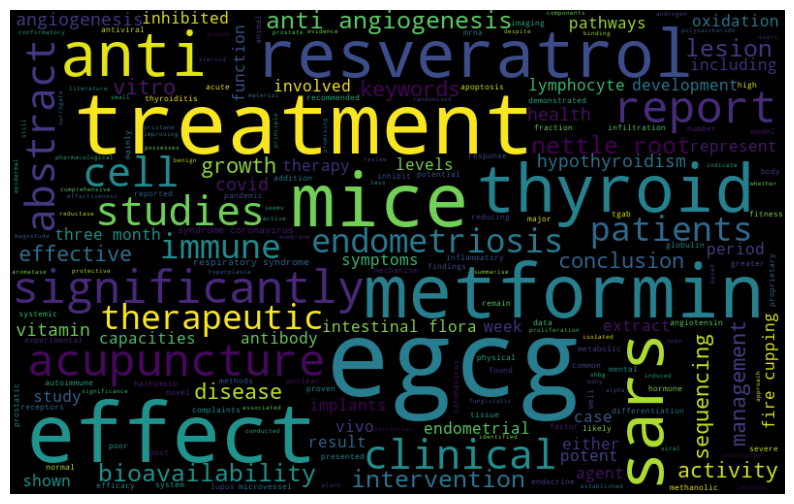

In [18]:
normal_words = ' '.join([text for text in two_scored_texts])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We see the words "effect", "effective", "therapeutic", "significantly, and "inhibited" as some of the most used ones. Others like "resveratrol", "thyroid", and "acupuncture" are here due to the way we took our texts - mainly with keywords for several diseases (one among them connected to the thyroid) and several health substances (resveratrol and egcg among them) and practices (acupuncture). In short - there is a very small variety in the kinds of disease and treatments, and this is the reason many of the words are here. But some of the most common look promising in the way that if we gather more diverse data, possibly some important keywords for scoring can emerge (or keep on showing).

If this happens, we can try algorithms for score prediction based on the most used words.

Wordcloud for 1-scored articles:

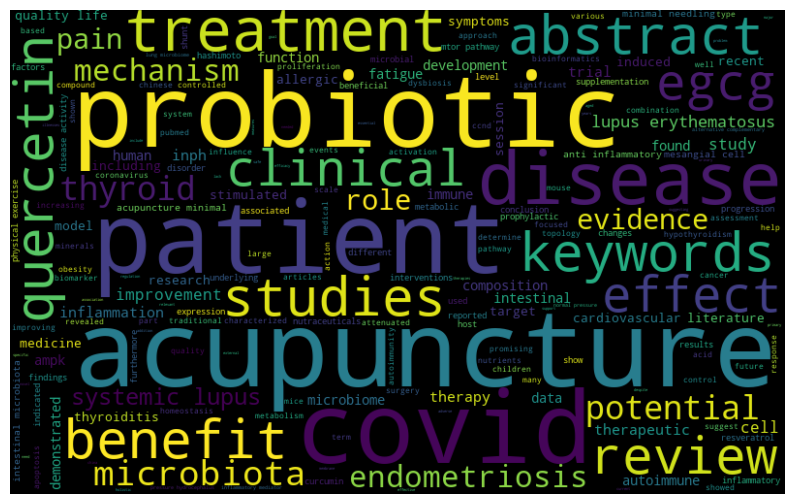

In [19]:
normal_words = ' '.join([text for text in one_scored_texts])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Beyond the words that we already pointed as a result of the way the data was gathered, here we see again promising words for the definition of our 1-scored texts - "benefit", "potential", and (again) "treatment", "effect".

Wordcloud for 0-scored articles:

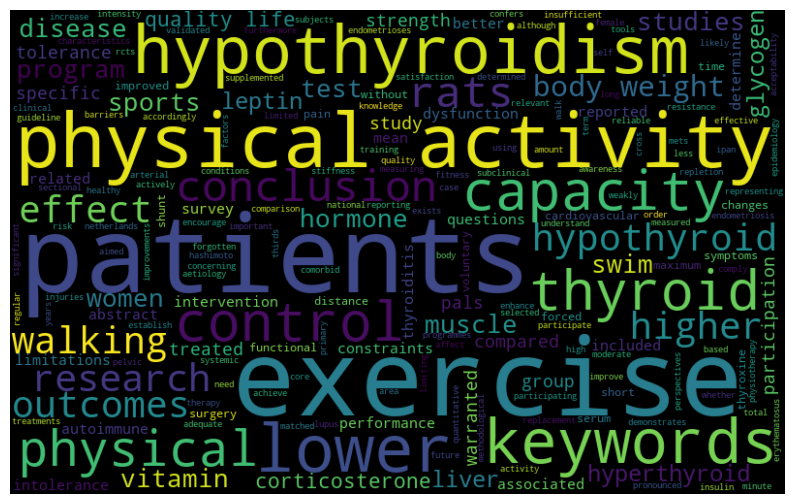

In [20]:
normal_words = ' '.join([text for text in zero_scored_texts])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We don't see any words that could lead to the conclusion that some treatment is successful. We see mainly neutral words.

The last cloud supports the observations above that the frequency of the words can help us in our text classification task (at least in distinguishing the '0' score from '1' and '2' scores).

##### Labels distribution

Let's see the distribution of the labels.

In [21]:
lbls = texts['score'].value_counts()

In [22]:
lbls.values

array([17,  8,  7], dtype=int64)

In [23]:
lbls.index

Int64Index([1, 2, 0], dtype='int64')

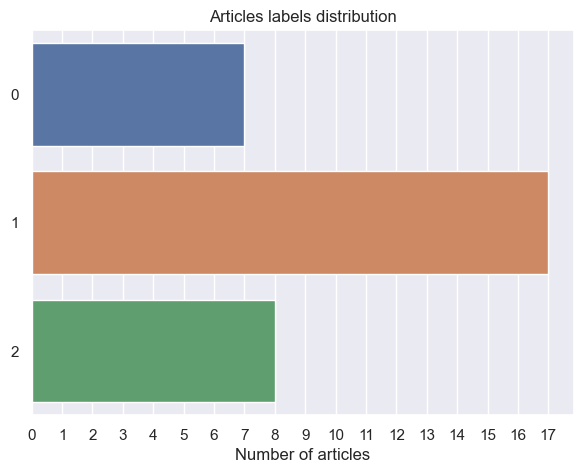

In [24]:
sns.set(rc={'figure.figsize':(7,5)})
sns.barplot(x=lbls.values, y = lbls.index,  orient="h")
plt.xticks(np.arange(0, max(lbls.values)+1, 1))
plt.title('Articles labels distribution')
plt.xlabel('Number of articles')
plt.show()

The articles are chosen randomly. So, what our random choice brought us? The articles with a score of '1' are more than double in comparison with the other texts. We have 17 one-scored, 8 two-scored, and 7 zero-scored papers. Roughly, it takes about 50% 1-scored, 25% 0- and 2-scored texts.

This means that if our algorithms choose '1' for scoring, the probability of being correct is bigger. For sure, they will do it.

There is a problem here. Since 2-scored texts might be the most important for the users, we don't want our algorithm to underestimate them. We will observe closely this disproportion and the algorithms' behavior.

#### Preprocessing

#### Train and test group

Even though our data is too small for training, we should allocate some for testing purposes as well. We consider 25% ideal for the case here - neither too big nor too small. This means we should take 8 articles apart. In order to create a stratified sample (to keep the label proportions (50%: 25%: 25%) we saw earlier), we will choose four articles with a '1' score, two with a '0', and two with a '2' score.

We will solve this problem easier with train_test_split. We can do it manually to ensure that sklearn will not lead to problems while building and training our algorithms. The problem comes later at the stage of tokenization. If we split them before, we should have two vocabularies (we don't want that). If we tokenize them it will be difficult to split them after that.

Now, we are going to make the capital letters small, remove extra space, accents, and smaller words (with 2 letters and fewer).

In [18]:
texts_list = texts['text'].values.tolist()

In [27]:
temp = []
#Splitting pd.Series to list
data_to_list = texts_list
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
data_words = list(sent_to_words(temp, 3))
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))

print(temp[:1])
print(data_words[:1])
print(data[:1])

['Conclusion: While there is conflicting evidence about the benefits of omega-3 fatty acid supplementation on SLE disease activity, specific measures have demonstrated benefits. Current data show that there is a potential benefit on disease activity as demonstrated by SLAM-R, Systemic Lupus Erythematosus Disease Activity Index (SLEDAI), and British Isles Lupus Assessment Group (BILAG) scores and plasma membrane arachidonic acid composition and urinary 8-isoprostane levels, with minimal adverse events. Keywords: Systemic lupus erythematosus; fish oil; omega-3 fatty acids.']
[['conclusion', 'while', 'there', 'conflicting', 'evidence', 'about', 'the', 'benefits', 'omega', 'fatty', 'acid', 'supplementation', 'sle', 'disease', 'activity', 'specific', 'measures', 'have', 'demonstrated', 'benefits', 'current', 'data', 'show', 'that', 'there', 'potential', 'benefit', 'disease', 'activity', 'demonstrated', 'slam', 'systemic', 'lupus', 'erythematosus', 'disease', 'activity', 'index', 'sledai', '

We should provide a number of the future vocabulary. In order for all the words to be included, we will fill in the number of all words from all texts (even though some words appear many times).

In [24]:
sum_of_strings = 0 
for text in data:
    sum_of_strings += len(text)

In [119]:
sum_of_strings

32325

The average length of an abstract is:

In [120]:
average_length = int(np.ceil(sum_of_strings/len(data)))
average_length

1011

Let's see what length has the largest abstract.

In [121]:
max = -sys.maxsize
for el in data:
    if len(el) > max:
        max = len(el)

In [122]:
max

1878

We are going to tokenize them and apply padding. The length that all the sequences will have, is that of the biggest text. The smaller sequences will be filled with zeros.

In [123]:
tokenizer = Tokenizer(num_words=sum_of_strings)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
res_and_trials = pad_sequences(sequences, maxlen=max)
print(res_and_trials)

[[   0    0    0 ...  367  368  613]
 [   0    0    0 ...    1  182   14]
 [   0    0    0 ...   79  659  393]
 ...
 [   0    0    0 ...  250   13  364]
 [   0    0    0 ... 1374  117  114]
 [   0    0    0 ...   29   49  110]]


Let's see how big the vocabulary of this tokenizer is actually:

In [124]:
sum_vocab_tokenizer = sum([x for _,x in tokenizer.word_counts.items()])

In [125]:
sum_vocab_tokenizer

4191

Since we are going to use Categorical cross-entropy, our labels should be one-hot encoded.

In [126]:
labels = texts['score']

In [127]:
labels = tf.keras.utils.to_categorical(labels, 3, dtype="float32")

Here we can see how our score is encoded. 0 is [1. 0. 0.], 1 is [0. 1. 0.] and 2 is [0. 0. 1.].

In [128]:
for num in range(10):
    print(f"Score: {texts['score'][num]}, one-hot encoded score: {labels[num]}")

Score: 1, one-hot encoded score: [0. 1. 0.]
Score: 2, one-hot encoded score: [0. 0. 1.]
Score: 2, one-hot encoded score: [0. 0. 1.]
Score: 1, one-hot encoded score: [0. 1. 0.]
Score: 2, one-hot encoded score: [0. 0. 1.]
Score: 1, one-hot encoded score: [0. 1. 0.]
Score: 2, one-hot encoded score: [0. 0. 1.]
Score: 1, one-hot encoded score: [0. 1. 0.]
Score: 0, one-hot encoded score: [1. 0. 0.]
Score: 0, one-hot encoded score: [1. 0. 0.]


Because we have an imbalanced dataset, we should stratify it when splitting the data into train and test datasets.

In [129]:
X_train, X_test, y_train, y_test = train_test_split(res_and_trials, labels, random_state=42, stratify=labels)
print (len(X_train),len(X_test),len(y_train),len(y_test))

24 8 24 8


## Models

### Building Networks

We are going to build and test three of the popular Deep Learning algorithms used for NLP tasks: Long Short-term Memory Networks, Bidirectional LSTM model, and 1D Convolutional model. 

LSTMs are a type of recurrent neural networks (RNN). They, as the RNN, keep information about past inputs for some period of time that depends on weights and on the input data. Therefore, they are capable to save information about the context and use this context for predictions. 

The problem though is that in reality in the case of RNNs the influence of a given input on the hidden layer, and therefore on the network output, either decays or blows up exponentially (the effect of the vanishing gradients and the exploding gradients). 

LSTMs manage to overcome this problem. Their hidden layer contains memory cells with constant error flow passing through. It makes very long time lags possible. The gate units learn to open and close access to error flow and thus protect the whole system from perturbation. 

What about the Bidirectional Networks? "The basic idea of bidirectional recurrent neural nets (...) is to present each training sequence forwards and backwards to two separate recurrent nets, both of which are connected to the same output layer. (...). This means that for every point in a given sequence, the BRNN has complete, sequential information about all points (...)". From <a href="https://www.sciencedirect.com/science/article/abs/pii/S0893608005001206" target="_blank">"Framewise phoneme classification with bidirectional LSTM and other neural network architectures"</a>.

1D Convolutional model as a convolution model has a kernel. But in Conv1D the kernel slides along one dimension, making it applicable to Time-Series data (and sequential data like texts). 

We will use the article <a href="https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91" target="_blank"> "An easy tutorial about Sentiment Analysis with Deep Learning and Keras"</a> as a starting point for our code. After that, we will try to find better hyperparameters, suitable for our dataset, for the best-performing model. 

#### LSTM

We will use the real volume of the vocabulary as the input dimension for the Embedding layer. The output dimension will be 20. 

In [130]:
model1 = Sequential()
model1.add(layers.Embedding(sum_vocab_tokenizer, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test),callbacks=[checkpoint1])


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 1.0974 - accuracy: 0.4167 - val_loss: 1.0938 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to best_model1.hdf5
Epoch 2/50
1/1 [==============================] - 0s 122ms/step - loss: 1.0949 - accuracy: 0.4583 - val_loss: 1.0923 - val_accuracy: 0.6250

Epoch 00002: val_accuracy improved from 0.50000 to 0.62500, saving model to best_model1.hdf5
Epoch 3/50
1/1 [==============================] - 0s 122ms/step - loss: 1.0935 - accuracy: 0.5833 - val_loss: 1.0909 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.62500
Epoch 4/50
1/1 [==============================] - 0s 123ms/step - loss: 1.0855 - accuracy: 0.7083 - val_loss: 1.0894 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.62500
Epoch 5/50
1/1 [==============================] - 0s 122ms/step - loss: 1.0847 - accuracy: 0.6250 - val_loss: 1.0879 - val_accuracy: 0.5000

Epoch

In [131]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          83820     
_________________________________________________________________
lstm (LSTM)                  (None, 15)                2160      
_________________________________________________________________
dense (Dense)                (None, 3)                 48        
Total params: 86,028
Trainable params: 86,028
Non-trainable params: 0
_________________________________________________________________


We don't expect the val_accuracy to improve, because the val_loss starts increasing steadily. Let's see what the performance of the other models will be.

#### Bidirectional LTSM model

In [132]:
bidirectional_model = Sequential()
bidirectional_model.add(layers.Embedding(sum_vocab_tokenizer, 20))
bidirectional_model.add(layers.Bidirectional(layers.LSTM(15, return_sequences=True))),
bidirectional_model.add(layers.Bidirectional(layers.LSTM(15)))
bidirectional_model.add(layers.Dense(3, activation="softmax"))

bidirectional_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint1 = ModelCheckpoint("best_model_bidirectional_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = bidirectional_model.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 1.0990 - accuracy: 0.2083 - val_loss: 1.0917 - val_accuracy: 0.3750

Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to best_model_bidirectional_model.hdf5
Epoch 2/50
1/1 [==============================] - 0s 425ms/step - loss: 1.0930 - accuracy: 0.4583 - val_loss: 1.0879 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.37500 to 0.50000, saving model to best_model_bidirectional_model.hdf5
Epoch 3/50
1/1 [==============================] - 0s 421ms/step - loss: 1.0872 - accuracy: 0.5417 - val_loss: 1.0842 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/50
1/1 [==============================] - 0s 429ms/step - loss: 1.0814 - accuracy: 0.5417 - val_loss: 1.0805 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/50
1/1 [==============================] - 0s 421ms/step - loss: 1.0755 - accuracy: 0.5417 - val_loss

We don't see good results. 

#### What about Conv1D?

Because Conv1D tends to overfit, we follow strictly the code from the article we have already mentioned (<a href="https://medium.com/towards-data-science/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91" target="_blank">An easy tutorial about Sentiment Analysis...</a>). We make an exception for the adam optimizer (its performance was better than that of rmsprop - see the draft) and for the regularization (because our texts do not make the algorithm overfit so fast).

In [133]:
model_D = Sequential()
model_D.add(layers.Embedding(max, 40, input_length=max))
model_D.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model_D.add(layers.MaxPooling1D(5))
model_D.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model_D.add(layers.GlobalMaxPooling1D())
model_D.add(layers.Dense(3,activation='softmax'))
model_D.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint_D = ModelCheckpoint("best_model_D.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model_D.fit(X_train, y_train, epochs=350,validation_data=(X_test, y_test),callbacks=[checkpoint_D])

Epoch 1/350
1/1 [==============================] - 1s 940ms/step - loss: 6.6145 - accuracy: 0.5000 - val_loss: 6.5349 - val_accuracy: 0.3750

Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to best_model_D.hdf5
Epoch 2/350
1/1 [==============================] - 0s 22ms/step - loss: 6.5060 - accuracy: 0.7083 - val_loss: 6.4523 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.37500 to 0.50000, saving model to best_model_D.hdf5
Epoch 3/350
1/1 [==============================] - 0s 21ms/step - loss: 6.4041 - accuracy: 0.7500 - val_loss: 6.3706 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/350
1/1 [==============================] - 0s 22ms/step - loss: 6.3066 - accuracy: 0.7500 - val_loss: 6.2896 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/350
1/1 [==============================] - 0s 22ms/step - loss: 6.2121 - accuracy: 0.7500 - val_loss: 6.2094 - val_accuracy: 0.5000


After some trial and error (mainly with the regularization, the results above are from the last one) it didn't reach 0.75 accuracy.

So, we have good results from the LSTM and we will continue with this model here.

#### The Best Model

In [136]:
tf.keras.backend.clear_session()

We are not going to repeat the fine-tuning of our LSTM models in the draft. We have tested there different optimizers, different learning rates, different numbers of layers with different numbers of units, and different dropout values.

In [137]:
model_LSTM = Sequential()
model_LSTM.add(layers.Embedding(input_dim = sum_vocab_tokenizer, output_dim=300, input_length=max))
model_LSTM.add(layers.LSTM(15,dropout=0.5, return_sequences=True))
model_LSTM.add(layers.LSTM(15,dropout=0.5, return_sequences=True))
model_LSTM.add(layers.LSTM(15,dropout=0.5, return_sequences=True))
model_LSTM.add(layers.LSTM(10,dropout=0.5, return_sequences=True))
model_LSTM.add(layers.LSTM(10,dropout=0.5, return_sequences=True))
model_LSTM.add(layers.LSTM(10,dropout=0.5, return_sequences=True))
model_LSTM.add(layers.LSTM(5,dropout=0.1, return_sequences=True))
model_LSTM.add(layers.LSTM(5,dropout=0.1, return_sequences=True))
model_LSTM.add(layers.LSTM(5,dropout=0.1))
model_LSTM.add(layers.Dense(3,activation='softmax'))


model_LSTM.compile(optimizer=Adam(learning_rate = 0.001),loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model_LSTM.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model_LSTM.fit(X_train, y_train, epochs=150,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/150
1/1 [==============================] - 15s 15s/step - loss: 1.0986 - accuracy: 0.3333 - val_loss: 1.0976 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to best_model_LSTM.hdf5
Epoch 2/150
1/1 [==============================] - 1s 945ms/step - loss: 1.0972 - accuracy: 0.5417 - val_loss: 1.0967 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/150
1/1 [==============================] - 1s 960ms/step - loss: 1.0955 - accuracy: 0.5417 - val_loss: 1.0956 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/150
1/1 [==============================] - 1s 967ms/step - loss: 1.0939 - accuracy: 0.5417 - val_loss: 1.0945 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/150
1/1 [==============================] - 1s 951ms/step - loss: 1.0917 - accuracy: 0.5417 - val_loss: 1.0932 - val_accuracy: 0.5000

Epoch 00005: val_accuracy did no

The more layers (almost all with 0.5 dropout) that we added protected the model from overfitting. We can see that it slowly and carefully improves the results. Unfortunately, neither in our draft nor here we managed to break the 0.75 accuracy barrier.

Let's see where our model makes mistakes.

In [251]:
#Make list with the predicted values taking out the biggest for every observation
pred = model_LSTM.predict(X_test)
pred_list = []
for line in pred:
    pred_list.append(line.argmax())

#Do the same with the one-hot encoded labels while printing
for el_ind in range(len(pred_list)):
    print(f"Real score: {y_test[el_ind].argmax()}, predicted score: {pred_list[el_ind]}")

Real score: 2, predicted score: 1
Real score: 0, predicted score: 0
Real score: 0, predicted score: 0
Real score: 1, predicted score: 1
Real score: 1, predicted score: 1
Real score: 1, predicted score: 1
Real score: 2, predicted score: 1
Real score: 1, predicted score: 1


We see that the biggest problem our successful LSTM faces is to distinguish the '2' score from '1'. If we use it, we should feed it with more 2-scored texts.

### Hugging Face Transformers

In search of better performance, we have tested some pre-trained models like Seethal/sentiment_analysis_generic_dataset and cardiffnlp/twitter-roberta-base-sentiment (see the draft). The best performance among the models here was that of the new version of RoBERTa (cardiffnlp/twitter-roberta-base-sentiment-latest). Let's see it.

In [230]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

model = TFAutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest", from_pt=True)
classifier = pipeline(task="sentiment-analysis", model=model, tokenizer=tokenizer)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


We should prepare a testing group for the model because it wants raw data. We already did it manually in the BERT file and have ready-to-use indices. How was the choice made? You will see later when we look at that file.

In [252]:
test_indices = [28, 3, 11, 23, 20, 19, 1, 2]

In [232]:
test_group = texts.loc[testing_indices]

In [233]:
results = classifier(test_group['text'].values.tolist())

In [234]:
scores = test_group['score'].values.tolist()
for a_result_index in range(len(results)):
    print(f'{results[a_result_index].values()} - {scores[a_result_index]}') 

dict_values(['neutral', 0.8107389211654663]) - 1
dict_values(['neutral', 0.7849499583244324]) - 1
dict_values(['neutral', 0.8527305722236633]) - 0
dict_values(['neutral', 0.6092937588691711]) - 0
dict_values(['neutral', 0.701647937297821]) - 1
dict_values(['neutral', 0.8254386782646179]) - 1
dict_values(['positive', 0.6713623404502869]) - 2
dict_values(['neutral', 0.858941376209259]) - 2


It seems that it didn't cope with the testing data. It made mistakes with all zeros (two examples) and one with a '2' score. Five out of eight is not very good performance (0.625 accuracy).

It is promising, though, and it can be trained. Due to limited resources, we couldn't do it in our draft.
RoBERTa is the Meta improved version of Google's BERT algorithm. We are going to test BERT as well.

### Other pre-trained models

Due to our limited resources, we had to move our work into the Colab space. Thanks to Google's GPUs and memory we managed to train Universal Language Model Fine-tuning for Text Classification (ULMFiT) and Bidirectional Encoder Representations from Transformers (BERT).
The code for both algorithms, introductory words for them, and tests can be found in the files, located in the "models" folder of this project, in directories "ULMFiT" and "BERT".
With the first algorithm, we achieved 0.833 accuracy. The second one (pre-trained on PubMed articles): the winning 0.875 accuracy. 